In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn.linear_model import LinearRegression

In [6]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

In [7]:
device_messages = df_mess_train.join(pos_train)[['messid', 'did', 'lat', 'lng']].drop_duplicates().rename(columns={"lat": "bs_lat", "lng": "bs_lng", "did": "id"})
device_messages['couleur']='device'
device_messages['rssi']=(np.ones(len(device_messages))*0).astype(int)
device_messages.head()
base_infos = df_mess_train[['messid','bsid', 'bs_lat', 'bs_lng', "rssi"]].rename(columns={"bsid": "id"})
base_infos['couleur']='base'
base_infos = base_infos.groupby('id').aggregate(lambda tdf: tdf.unique().tolist() 
                                                if len(tdf.unique().tolist()) >1 
                                                else tdf.unique()).reset_index()
df = pd.concat([base_infos,device_messages], sort=True)
import plotly.express as px
fig = px.scatter_mapbox(df, lat="bs_lat", lon="bs_lng", hover_name="id",
                        hover_data=["messid", "rssi"], color_discrete_sequence=["fuchsia", "red"], color="couleur",zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [8]:
df_mess_train.head()

messid  bsid       did  nseq   rssi       time_ux  \
0  573bf1d9864fce1a9af8c5c9  2841  473335.0   0.5 -121.5  1.463546e+12   
1  573bf1d9864fce1a9af8c5c9  3526  473335.0   2.0 -125.0  1.463546e+12   
2  573bf3533e952e19126b256a  2605  473335.0   1.0 -134.0  1.463547e+12   
3  573c0cd0f0fe6e735a699b93  2610  473953.0   2.0 -132.0  1.463553e+12   
4  573c0cd0f0fe6e735a699b93  3574  473953.0   1.0 -120.0  1.463553e+12   

      bs_lat      bs_lng  
0  39.617794 -104.954917  
1  39.677251 -104.952721  
2  39.612745 -105.008827  
3  39.797969 -105.073460  
4  39.723151 -104.956216

In [9]:
df_mess_train.describe()

bsid           did          nseq          rssi       time_ux  \
count  39250.000000  3.925000e+04  39250.000000  39250.000000  3.925000e+04   
mean    4533.774752  4.835932e+05      1.043541   -125.863580  1.473368e+12   
std     2570.495638  9.893140e+04      0.563540      9.226500  5.506910e+09   
min      879.000000  4.732880e+05      0.000000   -155.000000  1.463546e+12   
25%     2790.000000  4.761230e+05      1.000000   -132.500000  1.468410e+12   
50%     3559.000000  4.763150e+05      1.000000   -127.333333  1.473444e+12   
75%     7456.000000  4.766090e+05      1.500000   -121.000000  1.479118e+12   
max    11951.000000  1.747448e+06      2.000000    -64.000000  1.481143e+12   

             bs_lat        bs_lng  
count  39250.000000  39250.000000  
mean      42.554998   -100.969685  
std        7.722787     11.522732  
min       36.053394   -107.463146  
25%       39.747448   -105.074287  
50%       39.793585   -105.043685  
75%       39.838740   -104.998429  
max       64.300000    -68.500000

In [10]:
pos_train.head()

lat         lng
0  39.606690 -104.958490
1  39.606690 -104.958490
2  39.637741 -104.958554
3  39.730417 -104.968940
4  39.730417 -104.968940

In [11]:
pos_train.describe()

lat           lng
count  39250.000000  39250.000000
mean      39.783333   -105.056343
std        0.206262      0.162954
min       35.770683   -107.630679
25%       39.708599   -105.060463
50%       39.776882   -105.039440
75%       39.805279   -105.018730
max       43.140387   -102.094289

In [12]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [89]:
# Feature Matrix construction 

def feat_mat_const(df_mess_train):

    #pd.get_dummies(df_mess_train[['messid','bsid']], columns=['bsid']).groupby(['messid'], as_index=False).sum()
    # useful to get 0 or 1 associated with the base
    base_to_rssi = df_mess_train.pivot(index='messid', columns='bsid', values='rssi').reset_index().rename_axis(None, axis=1)
    base_to_lon = df_mess_train.pivot(index='messid', columns='bsid', values='bs_lng').reset_index().rename_axis(None, axis=1).drop('messid',axis=1)
    base_to_lat = df_mess_train.pivot(index='messid', columns='bsid', values='bs_lat').reset_index().rename_axis(None, axis=1).drop('messid',axis=1)
    return pd.concat([base_to_rssi, base_to_lon, base_to_lat], axis=1)

In [90]:
df_feat = feat_mat_const(df_mess_train)

#### Sanity check

In [91]:
df_feat[df_feat['messid']=='573c8ea8864fce1a9a5fbf7a'][['messid',9899]]

messid   9899        9899       9899
4  573c8ea8864fce1a9a5fbf7a -129.0 -105.026605  39.791402

In [92]:
df_mess_train[df_mess_train['bsid']==9899][df_mess_train['messid']=='573c8ea8864fce1a9a5fbf7a'][['messid','rssi','bs_lat','bs_lng']]

/home/savoga/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



messid   rssi     bs_lat      bs_lng
51  573c8ea8864fce1a9a5fbf7a -129.0  39.791402 -105.026605

In [56]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):
    ground_truth_lat = pos_train['lat']
    ground_truth_lng = pos_train['lng']
    return ground_truth_lat, ground_truth_lng

In [58]:
df_feat = feat_mat_const(df_mess_train, listOfBs)
df_feat.head()

rssi     bs_lat      bs_lng
0 -121.5  39.617794 -104.954917
1 -125.0  39.677251 -104.952721
2 -134.0  39.612745 -105.008827
3 -132.0  39.797969 -105.073460
4 -120.0  39.723151 -104.956216

In [59]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)

In [60]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

(39250,)

In [132]:
# Validation

In [133]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng
    
    reg = LinearRegression().fit(df_feat, pos_train)
    return reg.predict(feat_mat_const(df_test))#y_pred_lat, y_pred_lng


In [134]:
# Make regressor and prediction using the train set

In [146]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat)

In [136]:
# Cross validation

In [139]:
# Evaluate result

In [140]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [141]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [147]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

In [148]:
# Plot error distribution

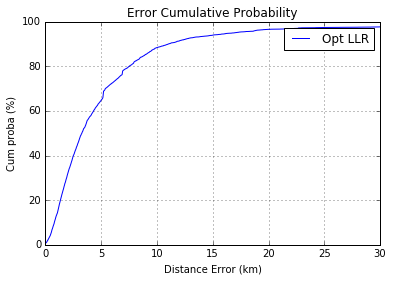

In [149]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [150]:
# Error criterion

np.percentile(err_vec, 80)

7522.0667120795024

In [151]:
# Construct test prediction